# Prepare (Glass + Gunshot) / 准备（玻璃+枪声）

Load multi-source meta, clean and resample all audio to 22.05k mono, then proceed to folds, analysis, and window planning. 读取多源 meta，清洗后重采样为22.05k单声道，继续分折、分析与分窗规划。

## Imports / 导入

In [1]:
import wave
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import librosa
from IPython.display import Audio, display
from src.config import TARGET_LABELS, SEED, SR, PROJECT_ROOT
from src.meta_utils import load_meta_files, map_canonical_labels, deduplicate_meta, sample_gunshot_even, assign_folds_if_missing
from src.data_utils import load_audio, generate_aligned_windows
from src.viz import plot_wave_and_mel


## Config Override / 配置覆写
Set parameters for this run; defaults can move into config later. 设定本次流程参数，后续可移入 config 默认。

In [2]:
META_FILES = ['data/meta/esc50.csv', 'data/meta/gunshot_kaggle.csv', 'data/meta/freesound.csv']
LABEL_MAP = {'glass_breaking': 'glass', 'gunshot': 'gunshot'}
K_FOLDS = 5
RATIOS = {'glass': 3, 'gunshot': 3, 'background': 4}
MAX_DURATION = 6.0  # seconds
GUNSHOT_TARGET = 60  # total gunshot clips after sampling
TARGET_SR = 22050
RESAMPLED_ROOT = Path('cache/data_resampled')


## Load, map, dedup / 读取映射去重
- Load meta CSVs
- Map raw labels to canonical labels
- Deduplicate by md5/filepath
- Summary counts

读取 meta，映射标签，按 md5/路径去重，打印汇总。

In [3]:
meta_df = load_meta_files(META_FILES)
meta_df = map_canonical_labels(meta_df, label_map=LABEL_MAP, target_labels=TARGET_LABELS)
meta_df = deduplicate_meta(meta_df, subset=['md5','filepath'])
print('Total rows after dedup:', len(meta_df))
print('By source:', meta_df['source'].value_counts().to_dict())
print('By canonical_label:', meta_df['canonical_label'].value_counts().to_dict())


Total rows after dedup: 2860
By source: {'esc50': 2000, 'gunshot_kaggle': 851, 'freesound': 9}
By canonical_label: {'gunshot': 851, 'glass': 49, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


## Filter & gunshot sampling / 过滤与枪声抽样
- Drop clips longer than MAX_DURATION
- Evenly sample gunshot across weapon_id to total GUNSHOT_TARGET

过滤 >MAX_DURATION；枪声按 weapon_id 均匀抽样，总数 GUNSHOT_TARGET。

In [4]:
clean_df = meta_df[meta_df['duration_sec'] <= MAX_DURATION].copy()
gun_sampled = sample_gunshot_even(clean_df, target_label='gunshot', total=GUNSHOT_TARGET, seed=SEED)
non_gun = clean_df[clean_df['canonical_label'] != 'gunshot']
clean_df = pd.concat([non_gun, gun_sampled], ignore_index=True)
print('After filter & gun sampling:', len(clean_df))
print('Label counts:', clean_df['canonical_label'].value_counts().to_dict())


After filter & gun sampling: 2067
Label counts: {'gunshot': 60, 'glass': 47, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


## Resample to 22.05k mono / 重采样为22.05k单声道
Write resampled audio to cache/data_resampled and build resampled_df. 将重采样音频写到 cache/data_resampled，并生成 resampled_df。
⚠️ Loads & writes all clips; may take time/disk. 需加载并写出全部音频，耗时且占用磁盘。

In [5]:
RESAMPLED_ROOT = PROJECT_ROOT / RESAMPLED_ROOT
resampled_rows = []
for _, r in clean_df.iterrows():
    y_rs, sr_rs = load_audio(r, sr=TARGET_SR)
    rel = Path(r['filepath'])
    if rel.is_absolute():
        rel = rel.relative_to(PROJECT_ROOT)
    dst_path = RESAMPLED_ROOT / rel
    dst_path.parent.mkdir(parents=True, exist_ok=True)
    y_int16 = (y_rs * 32767).clip(-32768, 32767).astype('int16')
    with wave.open(dst_path.as_posix(), 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(TARGET_SR)
        wf.writeframes(y_int16.tobytes())
    frames = len(y_int16)
    resampled_rows.append({
        'sno': r.get('sno', len(resampled_rows)+1),
        'filepath': dst_path.relative_to(PROJECT_ROOT).as_posix(),
        'label': r.get('label'),
        'canonical_label': r.get('canonical_label'),
        'source': r.get('source'),
        'fold_id': r.get('fold_id',''),
        'duration_sec': round(frames / TARGET_SR, 3),
        'duration_samples': frames,
        'sr': TARGET_SR,
        'channels': 1,
        'bit_depth': 16,
        'md5': '',
        'extra_meta': r.get('extra_meta',''),
    })
resampled_df = pd.DataFrame(resampled_rows)
resampled_df['target_label'] = resampled_df['canonical_label']
print('Resampled rows:', len(resampled_df))
print('sr/ch after resample:', resampled_df['sr'].unique(), resampled_df['channels'].unique())
print('Label counts:', resampled_df['target_label'].value_counts().to_dict())


Resampled rows: 2067
sr/ch after resample: [22050] [1]
Label counts: {'gunshot': 60, 'glass': 47, 'snoring': 40, 'rain': 40, 'insects': 40, 'laughing': 40, 'hen': 40, 'engine': 40, 'breathing': 40, 'crying_baby': 40, 'hand_saw': 40, 'coughing': 40, 'toilet_flush': 40, 'helicopter': 40, 'pig': 40, 'washing_machine': 40, 'clock_tick': 40, 'sneezing': 40, 'rooster': 40, 'sea_waves': 40, 'siren': 40, 'cat': 40, 'door_wood_creaks': 40, 'crickets': 40, 'drinking_sipping': 40, 'dog': 40, 'chirping_birds': 40, 'pouring_water': 40, 'vacuum_cleaner': 40, 'thunderstorm': 40, 'door_wood_knock': 40, 'can_opening': 40, 'crow': 40, 'clapping': 40, 'fireworks': 40, 'chainsaw': 40, 'airplane': 40, 'mouse_click': 40, 'train': 40, 'car_horn': 40, 'sheep': 40, 'water_drops': 40, 'church_bells': 40, 'clock_alarm': 40, 'keyboard_typing': 40, 'wind': 40, 'footsteps': 40, 'frog': 40, 'cow': 40, 'brushing_teeth': 40, 'crackling_fire': 40}


## Fold assignment / 分配折
Assign folds (hash for missing) on resampled_df. 对重采样后的数据分折，缺失折用哈希补齐。

In [6]:
folded_df = assign_folds_if_missing(resampled_df, k=K_FOLDS, seed=SEED)
print('Fold distribution:', folded_df['fold_id'].value_counts().to_dict())
print('Label per fold:', folded_df.groupby(['fold_id','target_label']).size())


Fold distribution: {2: 419, 3: 418, 1: 411, 4: 410, 5: 409}
Label per fold: fold_id  target_label   
1        airplane           8
         breathing          8
         brushing_teeth     8
         can_opening        8
         car_horn           8
                           ..
5        train              8
         vacuum_cleaner     8
         washing_machine    8
         water_drops        8
         wind               8
Length: 255, dtype: int64


## Resampled check (sr/ch) / 重采样检查
Confirm recorded sr/ch are unified. 确认记录的 sr/ch 已统一。

In [7]:
print('Recorded sr:', folded_df['sr'].value_counts().to_dict())
print('Recorded channels:', folded_df['channels'].value_counts().to_dict())


Recorded sr: {22050: 2067}
Recorded channels: {1: 2067}


## Visual sanity check / 随机样本可视化
Plot wave and log-mel for a random resampled sample. 随机抽样画波形与 log-mel（已重采样）。

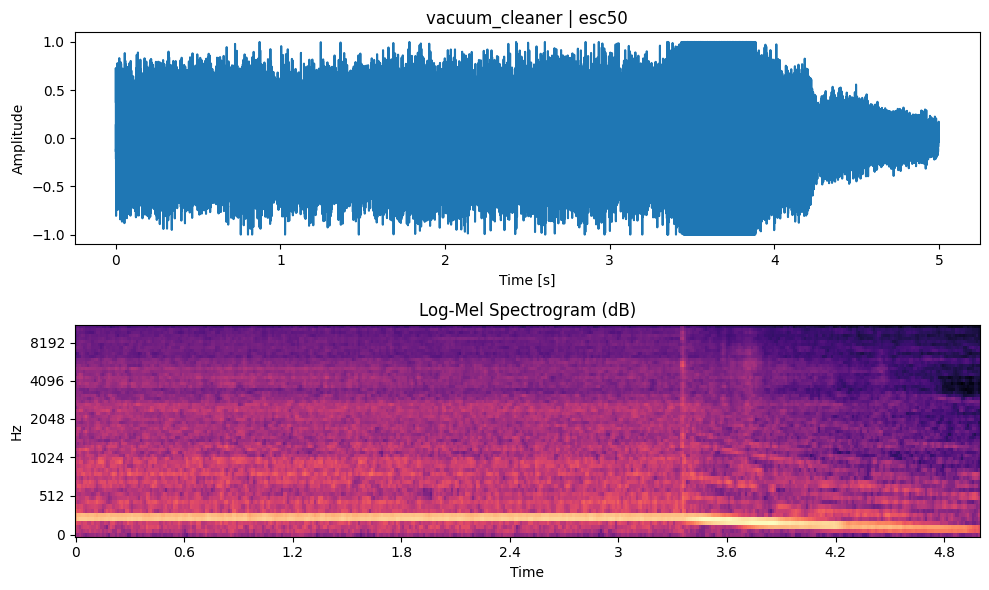

In [8]:
sample_row = folded_df.sample(random_state=SEED).iloc[0]
y, sr = load_audio(sample_row, sr=TARGET_SR)
plot_wave_and_mel(y=y, sr=sr, title=f"{sample_row['target_label']} | {sample_row['source']}")


## Energy analysis (glass & gunshot) / 能量分析
Sample clips, compute RMS/duration for window tuning. 抽样计算 RMS/时长供窗口调节。

Duration stats:
             mean       min   max
label                            
glass    4.670675  1.033424  5.04
gunshot  1.875000  1.000000  3.00
RMS max stats:
             mean       min       max
label                                
glass    0.279324  0.039080  0.844143
gunshot  0.284110  0.072101  0.553042


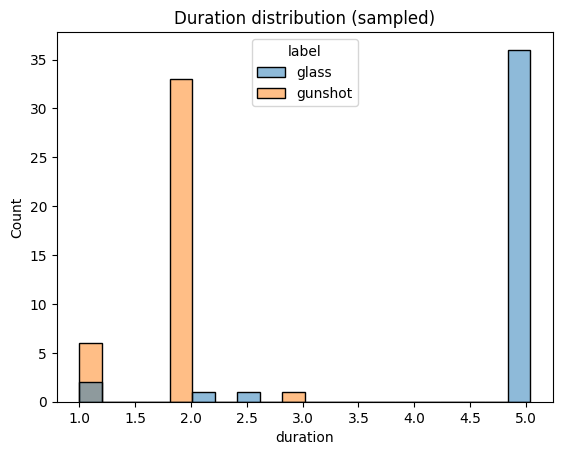

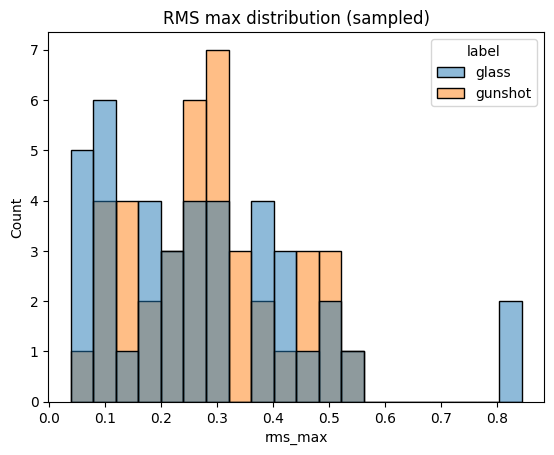

In [9]:
samples_energy = []
for lbl in ['glass','gunshot']:
    sub = folded_df[folded_df['target_label']==lbl]
    sub = sub.sample(n=min(40, len(sub)), random_state=SEED)
    for _, row in sub.iterrows():
        y, sr = load_audio(row, sr=TARGET_SR)
        rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
        samples_energy.append({'label': lbl, 'duration': len(y)/sr, 'rms_max': float(rms.max())})
energy_df = pd.DataFrame(samples_energy)
print('Duration stats:')
print(energy_df.groupby('label')['duration'].agg(['mean','min','max']))
print('RMS max stats:')
print(energy_df.groupby('label')['rms_max'].agg(['mean','min','max']))
sns.histplot(data=energy_df, x='duration', hue='label', bins=20)
plt.title('Duration distribution (sampled)')
plt.show()
sns.histplot(data=energy_df, x='rms_max', hue='label', bins=20)
plt.title('RMS max distribution (sampled)')
plt.show()


## Window config / 分窗配置
Override window/threshold parameters for this session. 本次会话窗口/阈值参数。

In [10]:
WINDOW_SECONDS = 1.0
WINDOW_HOP = 0.5
ENERGY_THRESHOLD = 0.3
PEAK_RATIO_THRESHOLD = 0.8
FRONT_PEAK_RATIO = 0.5
EXTRA_SHIFTS = (-0.1, 0.1)
TRIM_SILENCE_BEFORE = True
TRIM_TOP_DB = 20.0
TRIM_MIN_KEEP_SECONDS = 0.2
print(WINDOW_SECONDS, WINDOW_HOP, ENERGY_THRESHOLD, PEAK_RATIO_THRESHOLD, FRONT_PEAK_RATIO, EXTRA_SHIFTS, TRIM_SILENCE_BEFORE, TRIM_TOP_DB, TRIM_MIN_KEEP_SECONDS)


1.0 0.5 0.3 0.8 0.5 (-0.1, 0.1) True 20.0 0.2


## Base window summary / 基础分窗统计
Generate aligned windows for glass & gunshot, count per clip. 对玻璃/枪声分窗，统计每clip窗口数。

In [13]:
records = []
subset = folded_df[folded_df['target_label'].isin(['glass','gunshot'])]
for _, row in subset.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    records.append({'label': row['target_label'], 'clip': Path(row['filepath']).stem, 'n_windows': len(wins)})
base_df = pd.DataFrame(records)
print(base_df.groupby('label')['n_windows'].describe())


         count      mean       std  min  25%  50%  75%  max
label                                                      
glass     47.0  1.234043  0.786096  1.0  1.0  1.0  1.0  5.0
gunshot   60.0  1.083333  0.278718  1.0  1.0  1.0  1.0  2.0


## Window QA visualization / 分窗可视化QA
Plot waveform+RMS with kept window boundaries for one glass and one gunshot sample. 对玻璃/枪声各选一条，画波形+RMS并标出保留的窗口边界。


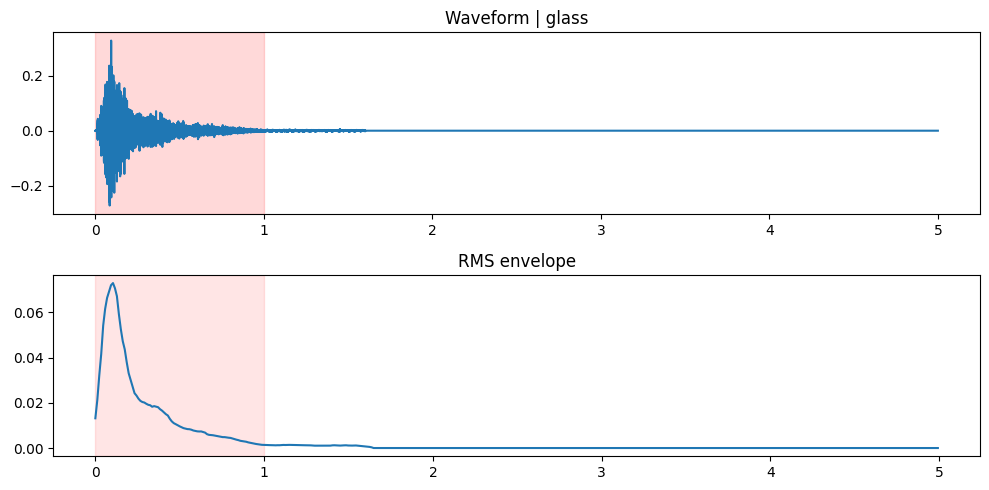

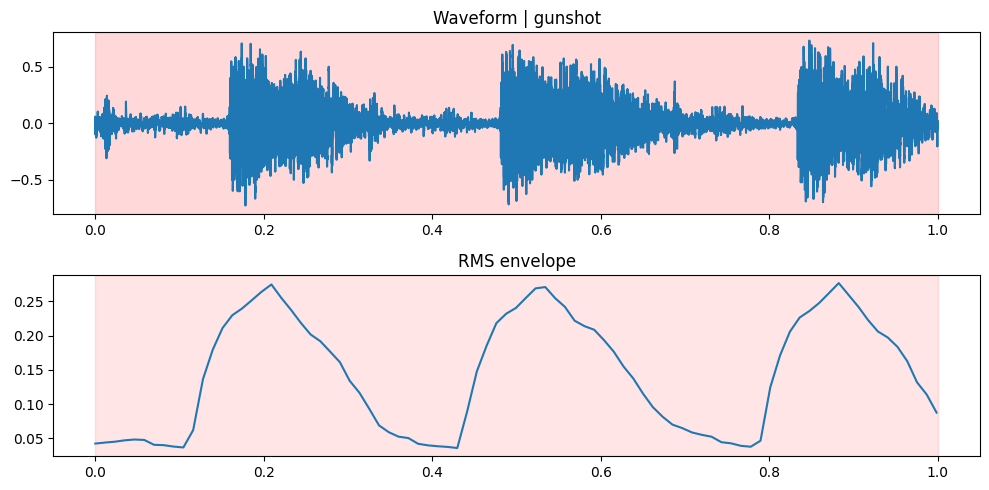

In [15]:
def plot_windows_for_row(row):
    y, sr = load_audio(row, sr=TARGET_SR)
    rms = librosa.feature.rms(y=y, frame_length=2048, hop_length=256)[0]
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    fig, ax = plt.subplots(2,1, figsize=(10,5), sharex=False)
    times = np.arange(len(y))/sr
    ax[0].plot(times, y)
    ax[0].set_title('Waveform | {}'.format(row.get('target_label','')))
    rms_times = np.arange(len(rms)) * 256 / sr
    ax[1].plot(rms_times, rms)
    ax[1].set_title('RMS envelope')
    for idx, _ in enumerate(wins):
        start = idx * WINDOW_HOP
        end = start + WINDOW_SECONDS
        ax[0].axvspan(start, end, color='red', alpha=0.15)
        ax[1].axvspan(start, end, color='red', alpha=0.1)
    plt.tight_layout(); plt.show()

glass_row = folded_df[folded_df['target_label']=='glass'].sample(random_state=SEED).iloc[0]
gun_row = folded_df[folded_df['target_label']=='gunshot'].sample(random_state=SEED).iloc[0]
plot_windows_for_row(glass_row)
plot_windows_for_row(gun_row)


## Listen: before vs after / 试听前后
Play original vs resampled audio for a few samples. 对比播放原始与重采样音频。

In [16]:
samples = folded_df.sample(n=min(5, len(folded_df)), random_state=SEED)
for _, r in samples.iterrows():
    y_after, sr_after = load_audio(r, sr=TARGET_SR)
    rel = Path(r['filepath']).relative_to('cache/data_resampled')
    raw_path = PROJECT_ROOT / rel
    y_before, sr_before = (None, None)
    if raw_path.exists():
        y_before, sr_before = load_audio({'filepath': raw_path}, sr=None)
    print('Sample:', r.get('target_label',''), '|', rel)
    if y_before is not None:
        display(Audio(y_before, rate=sr_before))
    display(Audio(y_after, rate=sr_after))
    print('-'*40)


Sample: vacuum_cleaner | data/esc50/audio/1-46744-A-36.wav


----------------------------------------
Sample: sea_waves | data/esc50/audio/2-132157-B-11.wav


----------------------------------------
Sample: train | data/esc50/audio/4-165845-A-45.wav


----------------------------------------
Sample: sea_waves | data/esc50/audio/1-39901-B-11.wav


----------------------------------------
Sample: sheep | data/esc50/audio/1-121951-A-8.wav


----------------------------------------


## Play 10 event windows / 播放10个事件窗口
Play up to 10 kept windows (glass/gunshot) for quick QA. 播放最多10个保留窗口，便于快速听检。


In [18]:
clips = folded_df[folded_df['target_label'].isin(['glass','gunshot'])].sample(frac=1.0, random_state=SEED)
played = 0
for _, row in clips.iterrows():
    wins = generate_aligned_windows(
        row,
        align_labels=['glass','gunshot'],
        extra_shifts=EXTRA_SHIFTS,
        energy_threshold=ENERGY_THRESHOLD,
        peak_ratio_threshold=PEAK_RATIO_THRESHOLD,
        front_peak_ratio=FRONT_PEAK_RATIO,
        trim_silence_before=TRIM_SILENCE_BEFORE,
        trim_top_db=TRIM_TOP_DB,
        trim_min_keep_seconds=TRIM_MIN_KEEP_SECONDS,
    )
    for w_idx, w in enumerate(wins):
        print('{} | {} | window {}'.format(row['target_label'], Path(row['filepath']).stem, w_idx))
        display(Audio(w, rate=TARGET_SR))
        played += 1
        if played >= 10:
            break
    if played >= 10:
        break
if played == 0:
    print('No windows to play')


gunshot | 6 (86) | window 0


gunshot | 6 (86) | window 1


glass | 2-112213-B-39 | window 0


glass | 2-112213-B-39 | window 1


glass | 1-85168-A-39 | window 0


gunshot | 9 (26) | window 0


gunshot | 5 (44) | window 0


gunshot | 5 (57) | window 0


glass | 4-204777-C-39 | window 0


glass | 4-204777-C-39 | window 1


## Next steps / 后续步骤
- Define augmentation plan and run smoke/full cache. 定义增强计划，跑 smoke/全量缓存。
- Fold balancing (glass:gun:background = 3:3:4) and QA sampling. 按 3:3:4 平衡折分并做 QA 抽样。
- Export balanced index for training. 导出平衡索引用于训练。